# Student Starter Code
### CS 181 Practical, Spring 2023
authors: Can Yeşildere, Benjamin James Elliott, Hrólfur Eyjófsson

This notebook contains starter code to:


*   **Load all of the data files** directly into your Colab runtime from the GCP bucket (so you don't need to download them to your computer!)
*   **Install libraries** inline, so you don't need to install them to your computer!




# Before you run this code:

1.   **Change your Runtime to use a GPU**: Click "Runtime" -> "Change Runtime Type", and select "GPU".
2.   **Stop Colab from disconnecting**:  To prevent Google Colab from disconnecting while you're away,  you can add an auto-click function using the Chrome console Just "Inspect", navigate to the "Console" and paste in this function:

```
function ClickConnect(){
    console.log("Clicked on connect button"); 
    document.querySelector("#ok").click()
}
setInterval(ClickConnect,60000)
```







In [1]:
! pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2955 sha256=42f795d107a1012bf523d9ac660c4e7aad28133eb9483712a78128b86ca7b041
  Stored in directory: /root/.cache/pip/wheels/f8/e0/3d/9d0c2020c44a519b9f02ab4fa6d2a4a996c98d79ab2f569fa1
Successfully built sklearn


In [27]:
import numpy as np
import matplotlib.pyplot as plt

# After you've installed a package, you can import it
import librosa

import sklearn 

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import pandas as pd

## Load the data files into local memory from the GCP bucket.

In [3]:
!gsutil cp gs://cs181_practical_data/Xtrain_amp.npy ./
!gsutil cp gs://cs181_practical_data/ytrain_amp.npy ./

!gsutil cp gs://cs181_practical_data/Xtest_amp.npy ./
!gsutil cp gs://cs181_practical_data/ytest_amp.npy ./

!gsutil cp gs://cs181_practical_data/Xtrain_mel.npy ./
!gsutil cp gs://cs181_practical_data/ytrain_mel.npy ./

!gsutil cp gs://cs181_practical_data/Xtest_mel.npy ./
!gsutil cp gs://cs181_practical_data/ytest_mel.npy ./

Copying gs://cs181_practical_data/Xtrain_amp.npy...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

\ [1 files][934.2 MiB/934.2 MiB]   19.8 MiB/s                                   
Operation completed over 1 objects/934.2 MiB.                                    
Copying gs://cs181_practical_data/ytrain_amp.npy...
/ [1 files][ 43.5 KiB/ 43.5 KiB]                                                
Operation completed over 1 objects/43.5 KiB.                                     
Copying gs://cs181_practical_data/Xtest_amp.npy...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

/ [1 files][369.6 MiB/369.6 M

### Load raw amplitude data as a numpy object.

In [4]:
# Load train data

X_amp_train = np.load("Xtrain_amp.npy")
y_amp_train = np.load("ytrain_amp.npy")

print(f"X_amp_train shape: {X_amp_train.shape}")

# Load test data

X_amp_test = np.load("Xtest_amp.npy")
y_amp_test = np.load("ytest_amp.npy")

print(f"X_amp_test shape: {X_amp_test.shape}")

X_amp_train shape: (5553, 44100)
X_amp_test shape: (2197, 44100)


### Load Mel spectrogram data as a numpy object.

In [6]:
# Load train data
X_mel_train = np.load("Xtrain_mel.npy")
y_mel_train = np.load("ytrain_mel.npy")

print(f"X_mel_train shape: {X_mel_train.shape}")

# Flatten X_mel_train's spectrogram features
X_mel_train_flat = X_mel_train.reshape(X_mel_train.shape[0], -1)
print(f"X_mel_train_flat shape: {X_mel_train_flat.shape}")

# Load test data
X_mel_test = np.load("Xtest_mel.npy")
y_mel_test = np.load("ytest_mel.npy")

print(f"X_mel_test shape: {X_mel_test.shape}")

X_mel_train shape: (5553, 128, 87)
X_mel_test shape: (2197, 128, 87)


# Training Models

We make this helper function to output our accuracy results into LaTeX

In [9]:
def acc_table(preds):
  # Generates accuracy table, LaTeX-friendly
  res_final = []
  accurate = []

  # Check which guesses are correct
  for i in range(len(y_amp_test)):
    if y_amp_test[i] == preds[i]:
      accurate.append(1)
    else:
      accurate.append(0)

  # Calculate the mean
  results = pd.DataFrame([accurate,y_amp_test]).T
  res_final.append(round(results[0].mean()*100,2))
  per_class =results.groupby(1).mean()
  res_final.append(round(per_class.mean()[0]*100,2))

  # Prediction accuracy for worst class
  res_final.append(np.argmin(per_class[0]))
  res_final.append(round(min(per_class[0]*100),2))

  # Prediction accuracy for best class
  res_final.append(np.argmax(per_class[0]))
  res_final.append(round(max(per_class[0])*100,2))

  # Make output LaTeX-friendly
  str_ = ''
  for item in res_final:
    str_ = str_ + str(item) + ' & '

  return str_[0:len(str_)-3]

## Baseline Linear Regressions

Run a linear regression without changing hyperparameters

In [ ]:
# Run a basic linear regression on the amplitude data
baseline_amp_logistic = LogisticRegression()
baseline_amp_logistic.fit(X_amp_train, y_amp_train)

In [10]:
# Collect predictions and get accuracy output for amplitude
baseline_amp_pred = baseline_amp_logistic.predict(X_amp_test)
acc_table(baseline_amp_pred)

'17.89 & 14.77 & 1 & 0.0 & 2 & 34.45'

In [11]:
# Run a basic linear regression on the mel spectogram data
baseline_mel_logistic = LogisticRegression(max_iter = 1000)
baseline_mel_logistic.fit(X_mel_train_flat, y_mel_train)

# Collect predictions and get accuracy output for mel data
baseline_mel_pred = baseline_mel_logistic.predict(X_mel_test.reshape(X_mel_test.shape[0], -1))  
acc_table(baseline_mel_pred)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

## Principal Convergence Analysis
Conduct principal convergence analysis to reduce the number of the dimensions

In [14]:
# Fit PCA to our data
pca = PCA()
X_train_all= np.hstack((X_amp_train,X_mel_train_flat))
pca.fit(X_train_all)

PCA()

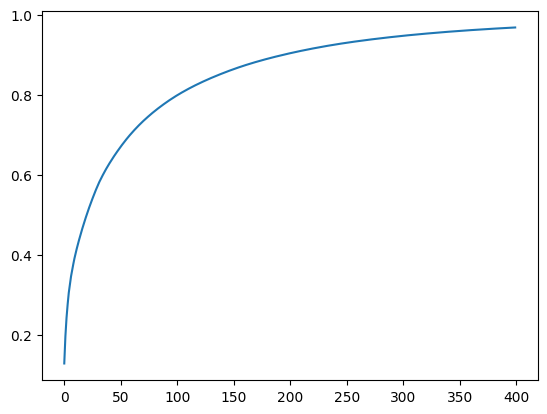

In [15]:
# Plot our PCA data
pre_var = 0
scree_plot = []
for var in pca.explained_variance_ratio_:
  pre_var += var
  scree_plot.append(pre_var)

plt.plot(scree_plot[0:400])

In [17]:
# Find where 99% is
for i in range(len(scree_plot)):
  if scree_plot[i]>.99:
    print(f"Variance explained by components exceeds 99% at {(i)}")
    break

Variance explained by components exceeds 99% at 693


In [18]:
# Refactor data
X_train_PCA =pca.transform(X_train_all)
X_test_all= np.hstack((X_amp_test,X_mel_test.reshape(X_mel_test.shape[0], -1)))
X_test_PCA = pca.transform(X_test_all)

## K-Nearest Neighbors
Make KNN using PCA. Our first guess, our baseline, is that having $700$ dimensions is a good start, since that is close to $693$, our value for the $99\%$ cutoff.

In [31]:
d = 700

neigh_k = KNeighborsClassifier()
neigh_k.fit(X_train_PCA[0:5553,0:d], y_amp_train)
pred = neigh_k.predict(X_test_PCA[0:2197,0:d])
print(acc_table(pred))

26.67 & 30.41 & 9 & 6.67 & 7 & 63.14


These results are suboptimal, so we try different dimensions and different neighbor counts.

In [32]:
# Make different KNN Models (i.e. varying k) for different dimensions
ks = range(1,100)
ds= [2,3,4,5,6,10,20,50,100,700]
scores_ = []
for d in ds:
  print(f"d: {d}")
  scores = []

  for k in tqdm(ks):
    # Train knn model on d dimensions
    neigh_k = KNeighborsClassifier(n_neighbors = k)
    neigh_k.fit(X_train_PCA[0:5553,0:d], y_amp_train)
    pred = neigh_k.predict(X_test_PCA[0:2197,0:d])
    true = 0
    for i in range(len(y_amp_test)):
      if y_amp_test[i] == pred[i]:
          true += 1

    scores.append(true/len(y_amp_test)*100)
  
  scores_.append(scores)

d: 2


100%|██████████| 99/99 [00:07<00:00, 12.65it/s]


d: 3


100%|██████████| 99/99 [00:11<00:00,  8.89it/s]


d: 4


100%|██████████| 99/99 [00:10<00:00,  9.33it/s]


d: 5


100%|██████████| 99/99 [00:15<00:00,  6.41it/s]


d: 6


100%|██████████| 99/99 [00:12<00:00,  8.17it/s]


d: 10


100%|██████████| 99/99 [00:16<00:00,  6.10it/s]


d: 20


100%|██████████| 99/99 [00:14<00:00,  7.04it/s]


d: 50


100%|██████████| 99/99 [00:16<00:00,  5.82it/s]


d: 100


100%|██████████| 99/99 [00:19<00:00,  5.07it/s]


d: 700


100%|██████████| 99/99 [01:09<00:00,  1.43it/s]


Text(0, 0.5, 'Classification Accuracy, %')

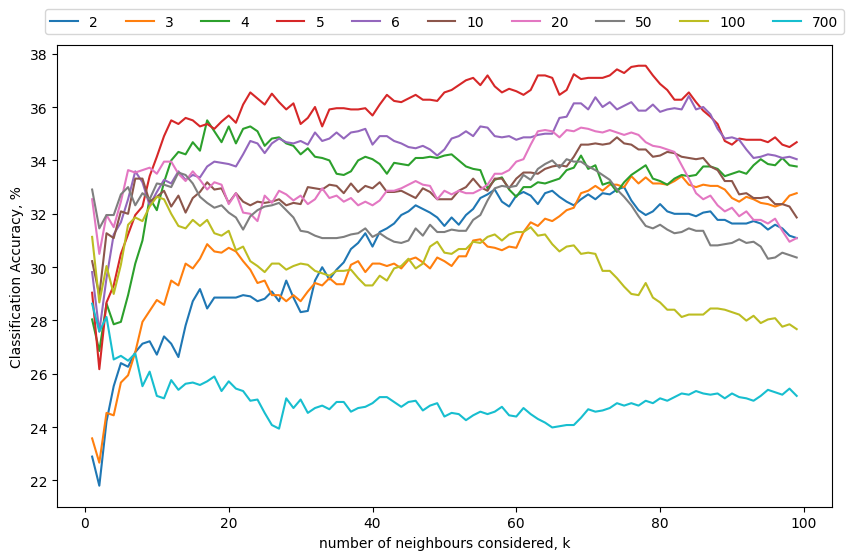

In [33]:
plt.figure(figsize=(10,6))
for i in range(len(scores_)):
  plt.plot(ks, scores_[i],label=ds[i])

plt.legend(loc = 'center',bbox_to_anchor=[0.5,1.05], ncol = len(scores_))
plt.title('')
plt.xlabel('number of neighbours considered, k')
plt.ylabel('Classification Accuracy, %')

$d = 5$ seems to be our best bet. We now find how many neighbors optimize that value. 

In [34]:
d = 5

neigh_k = KNeighborsClassifier(n_neighbors = (ks[np.argmax(scores_[3])]))
print(f"For d = 5, the optimal number of neighbors is {ks[np.argmax(scores_[3])]}")
neigh_k.fit(X_train_PCA[0:5553,0:d], y_amp_train)
pred = neigh_k.predict(X_test_PCA[0:2197,0:d])
print(acc_table(pred))

For d = 5, the optimal number of neighbors is 77
37.55 & 31.69 & 6 & 0.0 & 8 & 65.25


## Random Forest Classifier

We test the scores of RFC for several estimators counts and max depths.

In [ ]:
rfc_scores = {}
ks = [20,50,100,200,300,400,500,1000]
ds = [1,10,100,1000,None]
for d in ds:
  rfc_scores[d] = {}
  for k in tqdm(ks):
    rfc = RandomForestClassifier(n_estimators = k, max_depth = d)
    rfc.fit(X_train_PCA[0:5553,0:700], y_amp_train)

    pred =rfc.predict(X_test_PCA[0:5553,0:700])

    true = 0
    for i in range(len(y_amp_test)):
      if y_amp_test[i] == pred[i]:
          true += 1
    rfc_scores[d][k] = true/len(y_amp_test)
  print(rfc_scores)

We plot this information

Text(0, 0.5, 'Classification Accuracy, %')

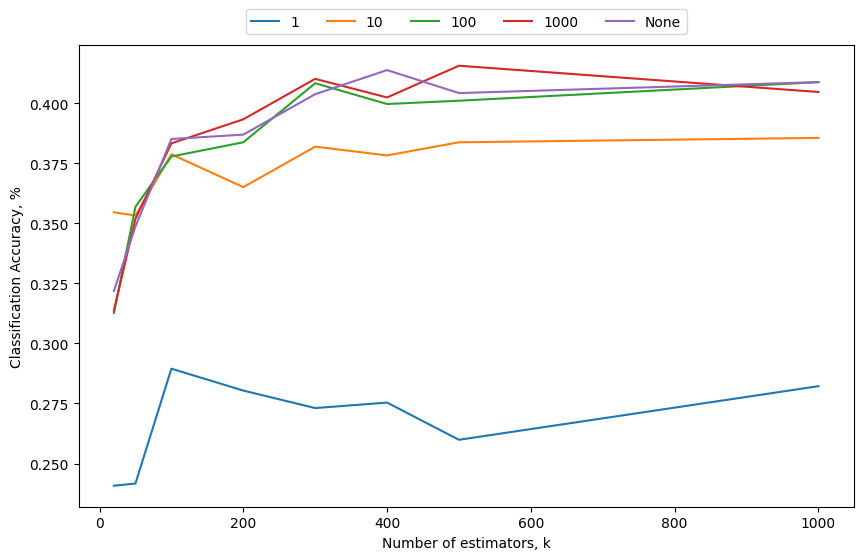

In [79]:
dict_scores = eval(np.array2string(rfc_scores))
plt.figure(figsize=(10,6))
for d, value in dict_scores.items():
  ks = value.keys()
  hell = value.values()
  plt.plot(ks, hell, label=(d or "None"))

plt.legend(loc = 'center',bbox_to_anchor=[0.5,1.05], ncol = len(scores_))
plt.title('')
plt.xlabel('Number of estimators, k')
plt.ylabel('Classification Accuracy, %')


We then find the accuracy values for the baseline model, our best model $(500,1000)$, and a smaller model that is fairly accurate, but is not so massive $(300,100)$.

In [77]:
baseline_rfc = RandomForestClassifier()
baseline_rfc.fit(X_train_PCA[0:5553,0:700], y_amp_train)
baseline_rfc_preds = baseline_rfc.predict(X_test_PCA[0:5553,0:700])
print(acc_table(baseline_rfc_preds))

37.55 & 33.65 & 6 & 6.67 & 8 & 63.56


In [82]:
best_rfc = RandomForestClassifier(n_estimators = 500, max_depth = 1000)
best_rfc.fit(X_train_PCA[0:5553,0:700], y_amp_train)
best_rfc_preds = best_rfc.predict(X_test_PCA[0:5553,0:700])
print(acc_table(best_rfc_preds))

41.28 & 36.17 & 6 & 6.67 & 2 & 64.21


In [81]:
efficient_rfc = RandomForestClassifier(n_estimators = 300, max_depth = 100)
efficient_rfc.fit(X_train_PCA[0:5553,0:700], y_amp_train)
efficient_rfc_preds = efficient_rfc.predict(X_test_PCA[0:5553,0:700])
print(acc_table(efficient_rfc_preds))

39.6 & 34.62 & 6 & 6.67 & 8 & 63.14
